In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('FIFA_train.csv',encoding = 'utf-8') # train data
test = pd.read_csv("FIFA_test.csv",encoding = 'utf-8') # test data
submission = pd.read_csv('submission.csv',encoding='utf-8')

In [3]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


### 파생변수

In [4]:
def create_new_variable(df):
    # 데이터프레임을 복사하여 새로운 데이터프레임을 생성
    new_df = df.copy()
    
    # position별로 stat_overall과 stat_potential의 평균을 구함
    position_stat = new_df.groupby('position')[['stat_overall', 'stat_potential']].mean()
    
    # 기존 데이터프레임과 position_stat를 join하여 새로운 데이터프레임을 생성
    new_df = new_df.join(position_stat.add_suffix('_mean'), on='position')
    
    # stat_overall_dif 변수와 sod*re 변수를 생성
    new_df['stat_overall_dif'] = new_df['stat_overall'] - new_df['stat_overall_mean']
    new_df['sod*re'] = new_df['stat_overall_dif'] * new_df['reputation']
    
    # stat_potential_dif 변수와 spd*re 변수를 생성
    new_df['stat_potential_dif'] = new_df['stat_potential'] - new_df['stat_potential_mean']
    new_df['spd*re'] = new_df['stat_potential_dif'] * new_df['reputation']
    
    # 수학적 기법인 가중조화평균을 이용해 가중치(reputation)으로 raw data에서 상관관계가 높은 변수로 만들어봄
    new_df['egi'] = (new_df['reputation'] ** 0.5 * (new_df['stat_overall'] * new_df['stat_potential']) ** 0.5) / (new_df['reputation'] ** 0.5 + (new_df['stat_overall'] * new_df['stat_potential']) ** 0.5)
    
    # 나이별 그룹을 만들어서 가중치를 두고 분석에 이용
    new_df['age_group'] = pd.cut(new_df['age'], 
                                 bins=[0, 20, 25, 30, 100], 
                                 labels=['under 20', '20-25', '26-30', 'over 30'])
    
    age_group_level_map = {
    'under 20' :    4,
    '20-25'    :    3, 
    '26-30'       :    2,
    'over 30'        :    1, 
    } 
    
    new_df['age_group_level'] = new_df['age_group'].map(age_group_level_map)
    new_df['age_group_level'] = new_df['age_group_level'].astype('float64')
    new_df['agl*spdre'] = new_df['age_group_level'] * new_df['spd*re']
    
    # 포지션별 선수 순위를 내림차순으로 정리하는 position_rank 변수 생성
    new_df['position_rank'] = new_df.groupby('position')['stat_overall'].rank(ascending=True)
    
    # position_rank를 가중치인 reputation 변수와 곱해 새로운 파생변수 생성(corr=0.68)
    new_df['position_rank*stat_potential']= new_df['position_rank'] * new_df['stat_potential']
    
    # 파생변수를 선택하여 반환
    return new_df[['sod*re', 'spd*re', 'egi', 'age_group', 'age_group_level', 'agl*spdre', 'position_rank', 'position_rank*stat_potential']]

In [5]:
train = pd.merge(train, create_new_variable(train), left_index=True, right_index=True)

<AxesSubplot:>

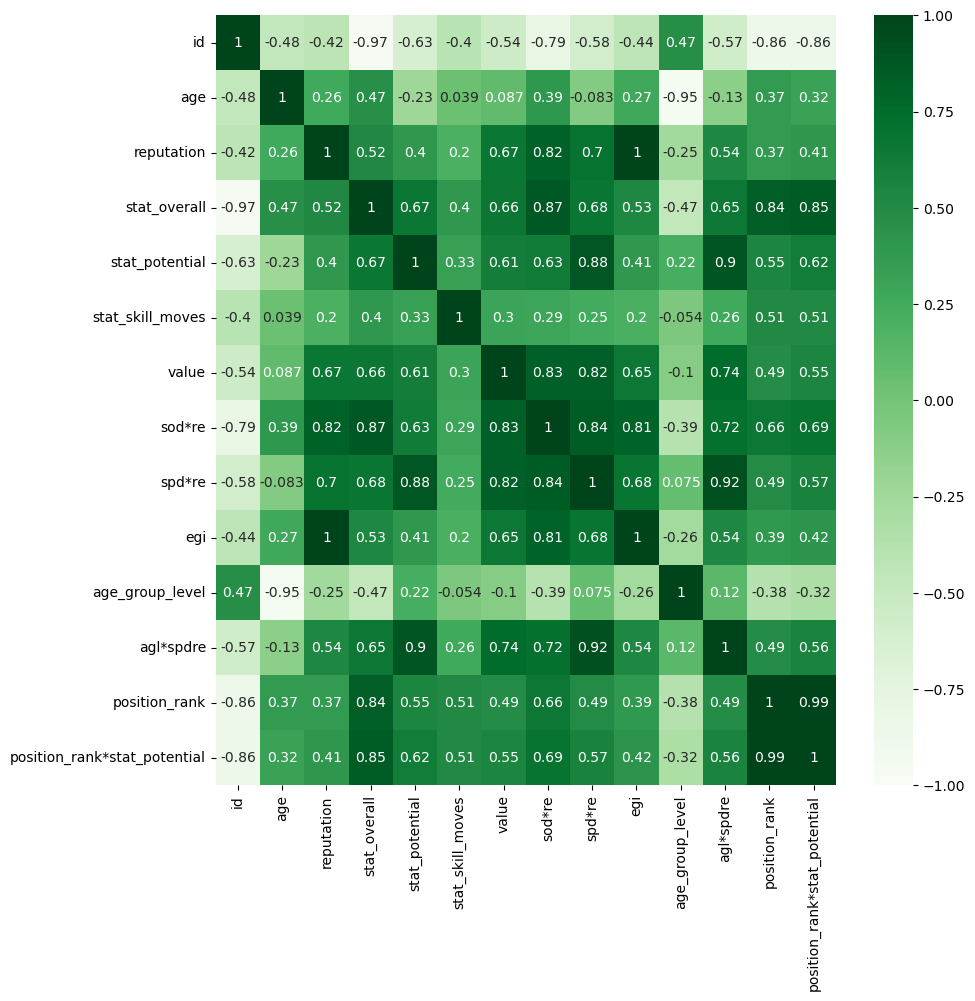

In [6]:
#heatmap으로 상관관계를 표시
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams["figure.figsize"] = (10,10)
sb.heatmap(train.corr(),
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
          )

In [7]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,sod*re,spd*re,egi,age_group,age_group_level,agl*spdre,position_rank,position_rank*stat_potential
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0,133.498534,107.149560,2.184112,over 30,1.0,107.149560,1705.0,160270.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0,103.246032,89.376984,1.957444,26-30,2.0,178.753968,1008.0,93744.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0,118.498534,92.149560,2.182441,over 30,1.0,92.149560,1704.0,155064.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0,94.783232,77.314224,1.956989,over 30,1.0,77.314224,2791.0,253981.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0,74.434524,67.032738,1.699869,20-25,3.0,201.098214,1007.0,93651.0


In [8]:
# Split features and target variable
X = train.drop(['value', 'id', 'name'], axis=1)
y = train["value"]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size = 0.3, random_state = 1, shuffle=True, stratify = X["reputation"]
)

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define column names for categorical and numerical features
categorical_cols = ['continent', 'contract_until', 'position', 'prefer_foot', 'reputation', 'stat_skill_moves', 'position_rank*stat_potential', 'position_rank']
numerical_cols = ['reputation','stat_overall', 'stat_potential', 'stat_skill_moves', 'sod*re', 'spd*re', 'egi', 'agl*spdre']

# Use pandas' select_dtypes method to select categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object'])
numerical_features = X_train.select_dtypes(include=['int64', 'float64'])

# Define transformers for preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

discrete_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features.columns),
    ('num', discrete_transformer, numerical_features.columns)
])

# Define Random Forest Regressor model
model = RandomForestRegressor()

# Define full pipeline including preprocessing and modeling
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline to the data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['continent', 'contract_until', 'position', 'prefer_foot'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'reputation', 'stat_overall', 'stat_potential',
       'stat_skill_moves', 'sod*re', 'spd*re', 'egi', 'age_group_level',
       'agl*spdre', 'position_rank', 'position_rank*stat_potential'],
      dtype='object'))])),
                ('model', RandomForestRegressor())])

In [11]:
from sklearn.metrics import mean_squared_error

# Predict on training data
y_train_pred = pipeline.predict(X_train)

# Calculate MSE
rmse = mean_squared_error(y_train, y_train_pred)**0.5
print('RMSE:', rmse)


RMSE: 408119.9939352224


In [12]:
from sklearn.metrics import mean_squared_error

# Predict on training data
y_test_pred = pipeline.predict(X_test)

# Calculate MSE
rmse = mean_squared_error(y_test, y_test_pred)**0.5
print('RMSE:', rmse)

RMSE: 1037018.2357222275


In [13]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# # Define column names for categorical and numerical features
# categorical_cols = ['continent', 'contract_until', 'position', 'prefer_foot', 'reputation', 'stat_skill_moves', 'position_rank*stat_potential', 'position_rank']
# numerical_cols = ['reputation','stat_overall', 'stat_potential', 'stat_skill_moves', 'sod*re', 'spd*re', 'egi', 'agl*spdre']

# Define transformers for preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

discrete_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', discrete_transformer, numerical_cols)
])

# Define Ridge Regression model
ridge_model = make_pipeline(preprocessor, Ridge())

# Define parameter grid for GridSearchCV
param_grid = {'ridge__alpha': [0.1, 1, 10, 100]}

# Define GridSearchCV object
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best alpha value found by GridSearchCV
print('Best alpha value:', grid_search.best_params_['ridge__alpha'])

# Define Random Forest Regressor model with the best alpha value found by GridSearchCV
rf_model = RandomForestRegressor()

# Define full pipeline including preprocessing and modeling with the best alpha value found by GridSearchCV
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

# Fit the pipeline to the data
pipeline.fit(X_train, y_train)

Best alpha value: 0.1


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['continent',
                                                   'contract_until', 'position',
                                                   'prefer_foot', 'reputation',
                                                   'stat_skill_moves',
                                                   'position_rank*stat_potential',
                                                   'position_rank']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['reputation', 'stat_overall',
                                                   'stat_potential',
                                                   'stat_skill_moves', 'sod*re',
                                                   'spd*re', 'egi',
                                                   'agl*spdre'])])),
                ('model', RandomForestRegressor())])

In [14]:
from sklearn.metrics import mean_squared_error

# Predict on training data
y_train_pred = pipeline.predict(X_train)

# Calculate MSE
rmse = mean_squared_error(y_train, y_train_pred)**0.5
print('RMSE:', rmse)

RMSE: 469485.94510846346


In [15]:
from sklearn.metrics import mean_squared_error

# Predict on training data
y_test_pred = pipeline.predict(X_test)

# Calculate MSE
rmse = mean_squared_error(y_test, y_test_pred)**0.5
print('RMSE:', rmse)

RMSE: 1315484.719016198


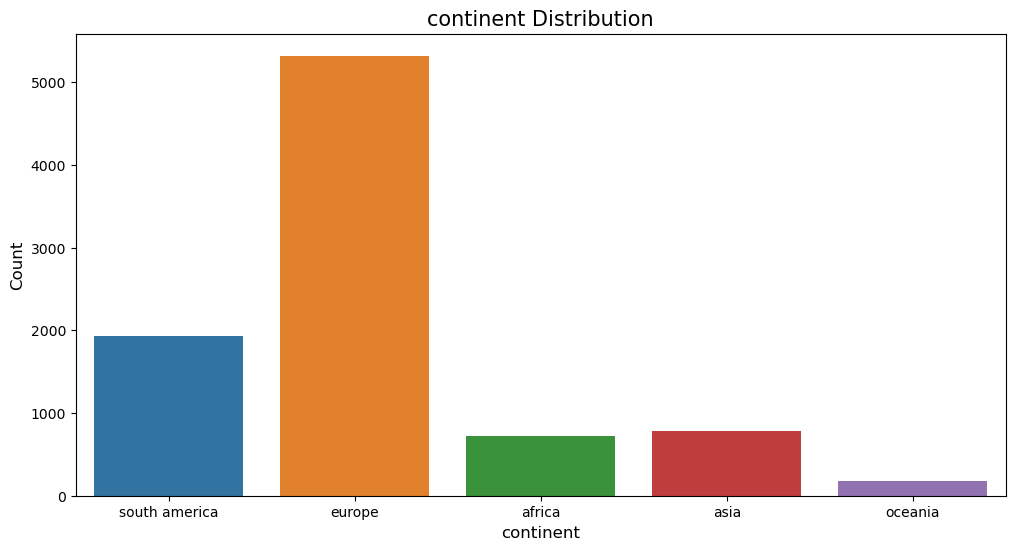

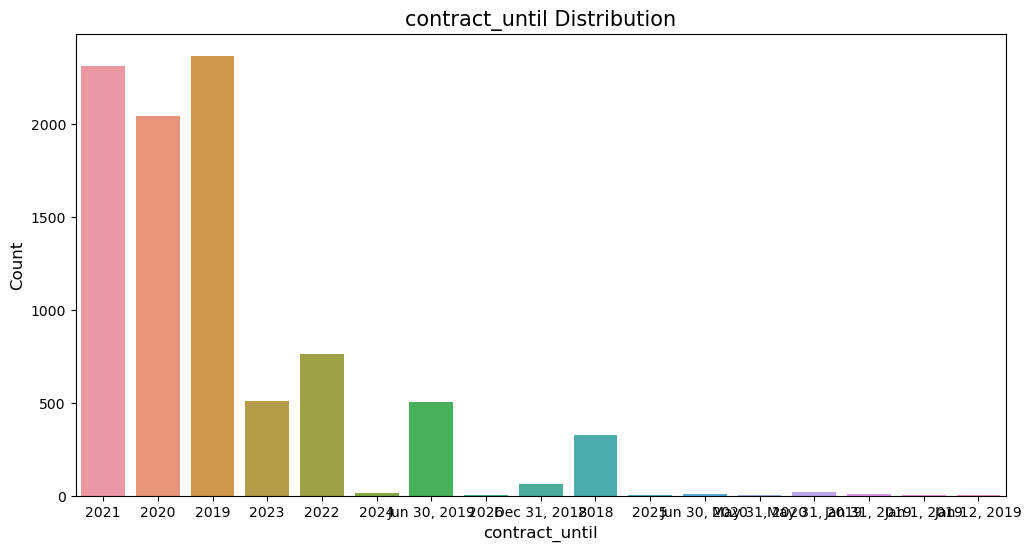

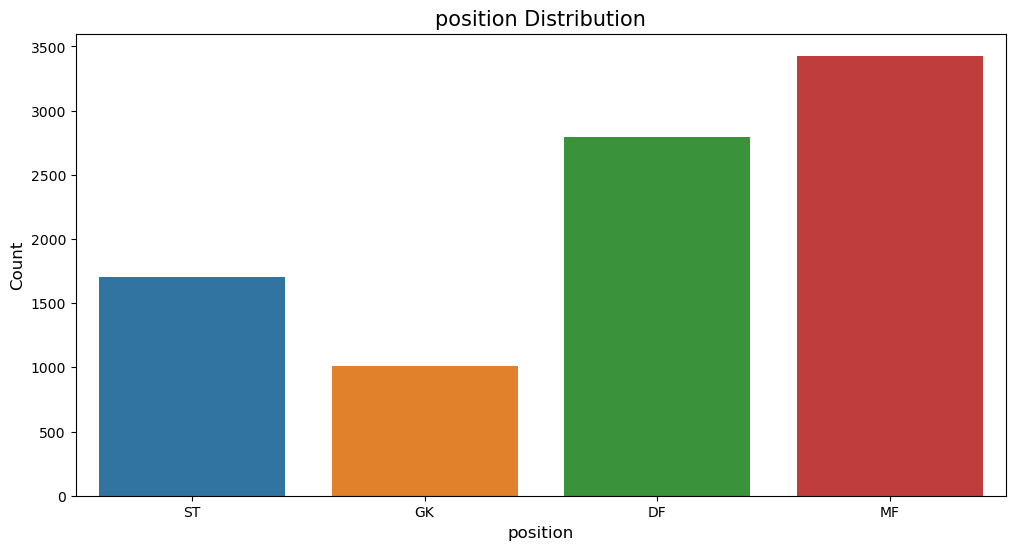

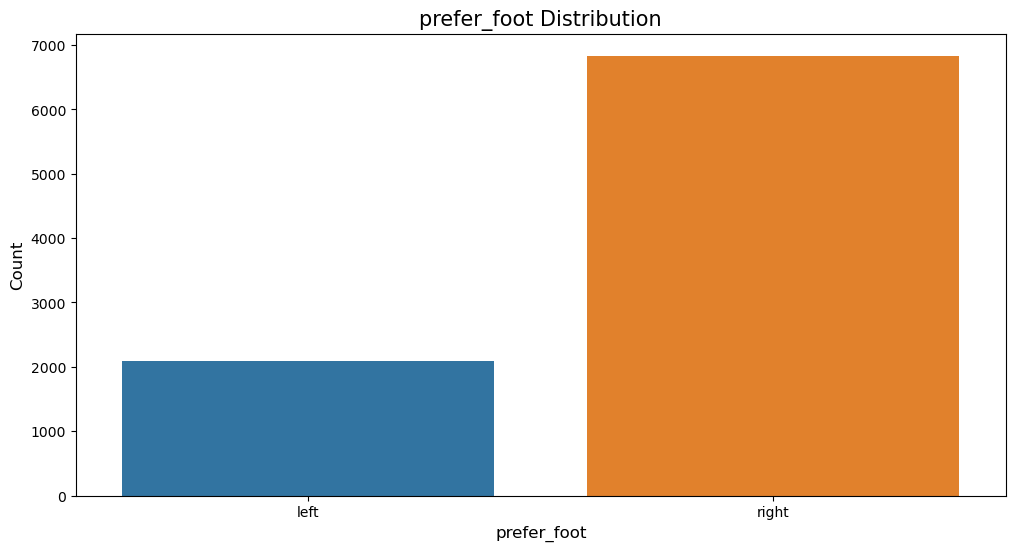

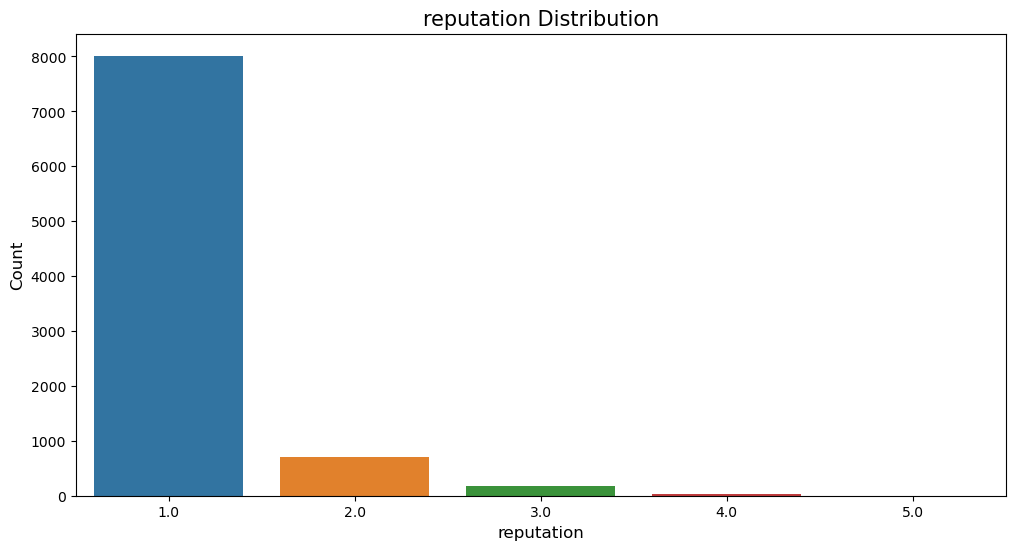

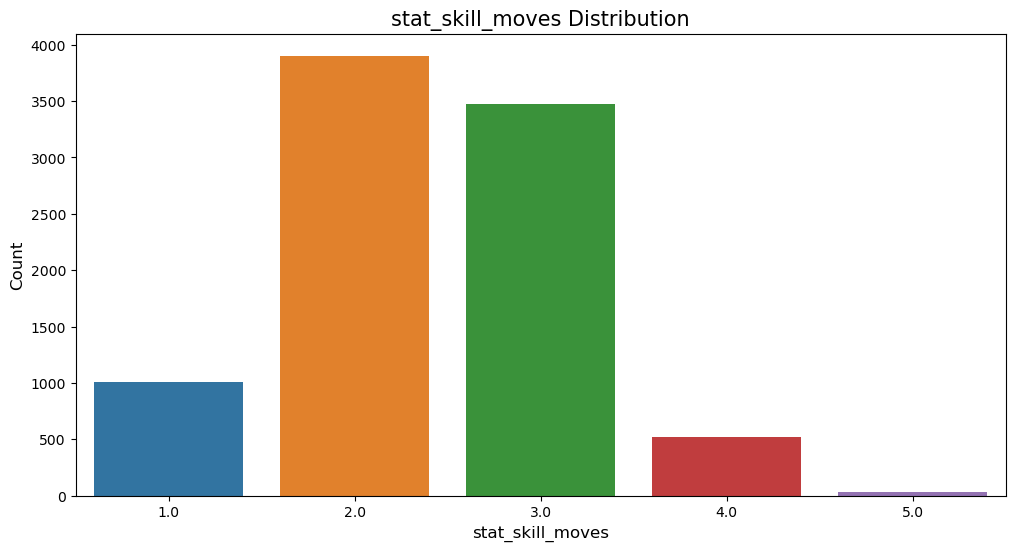

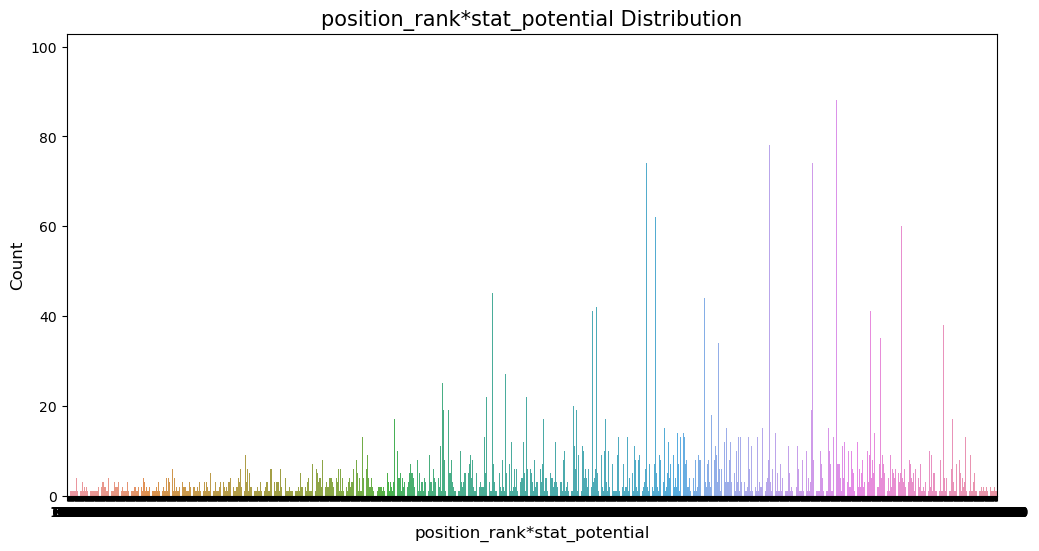

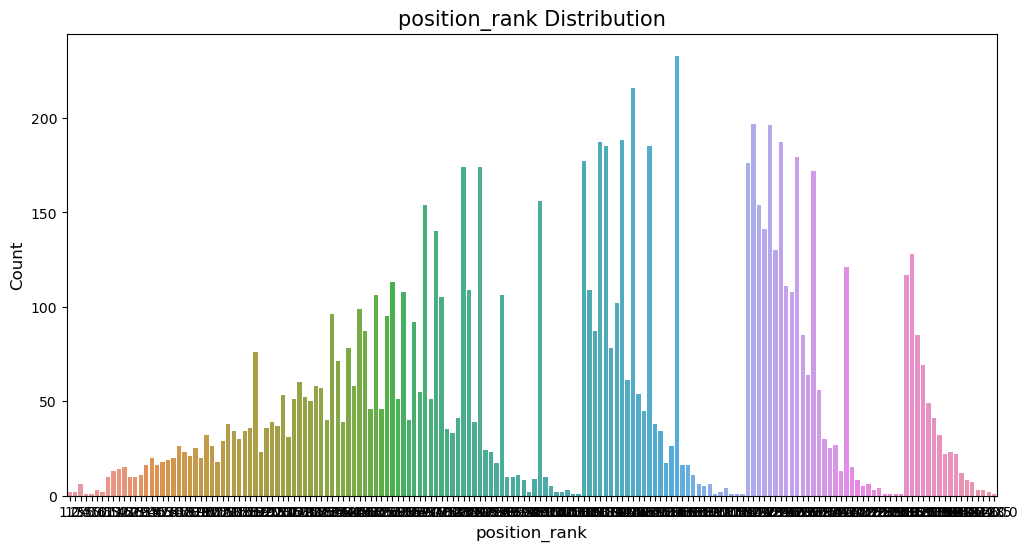

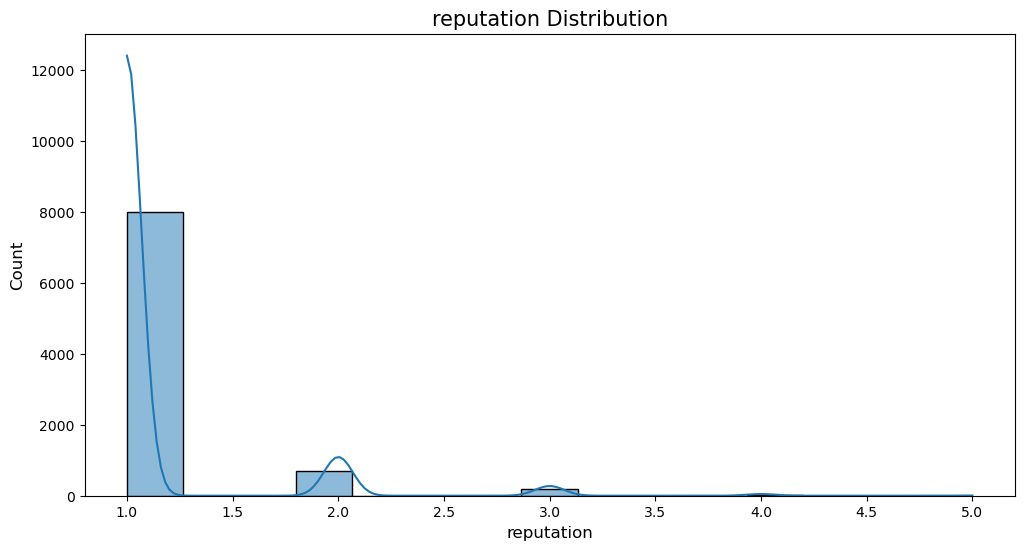

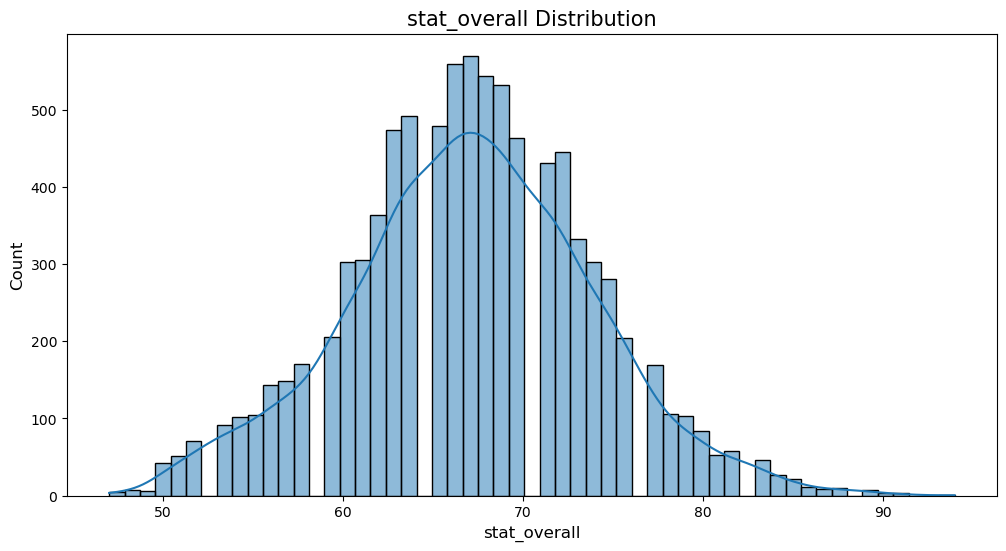

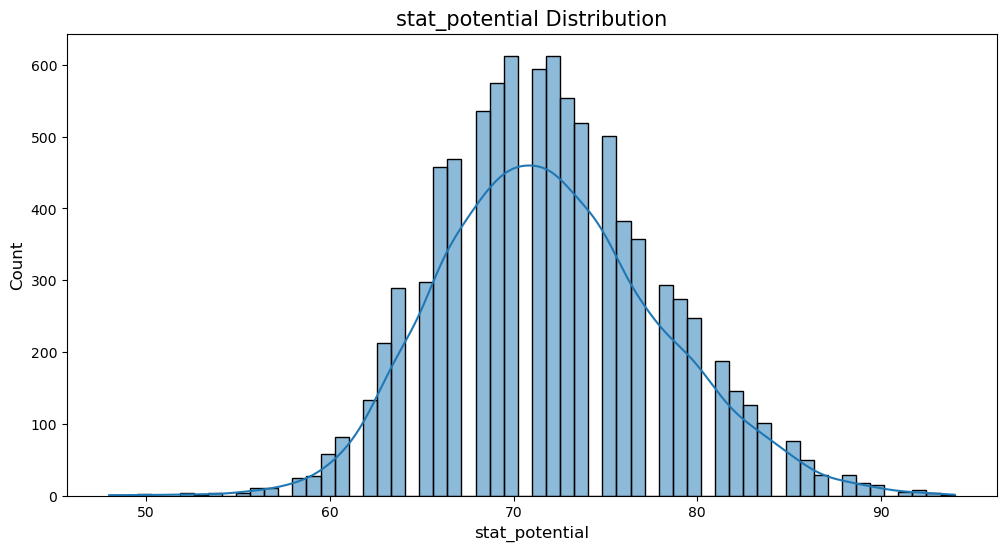

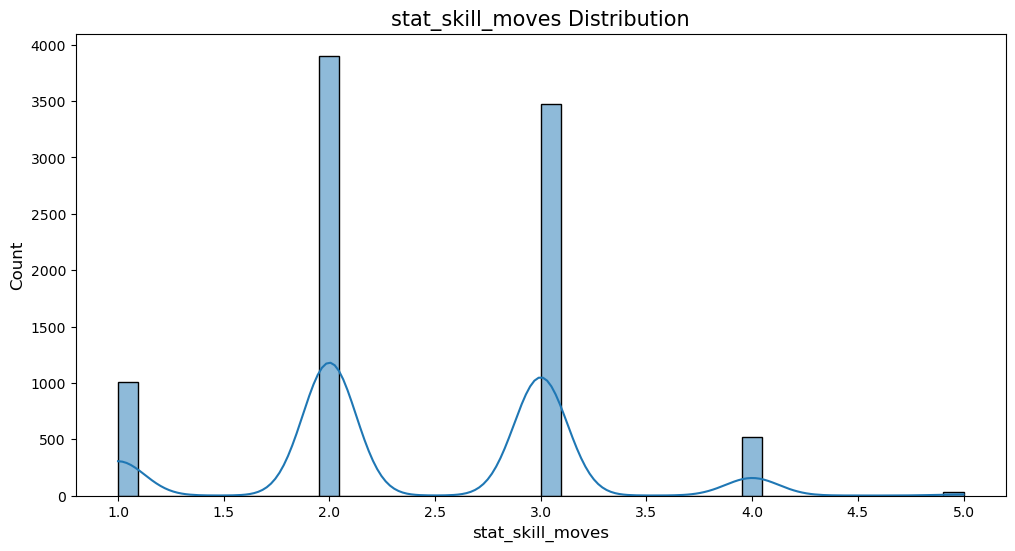

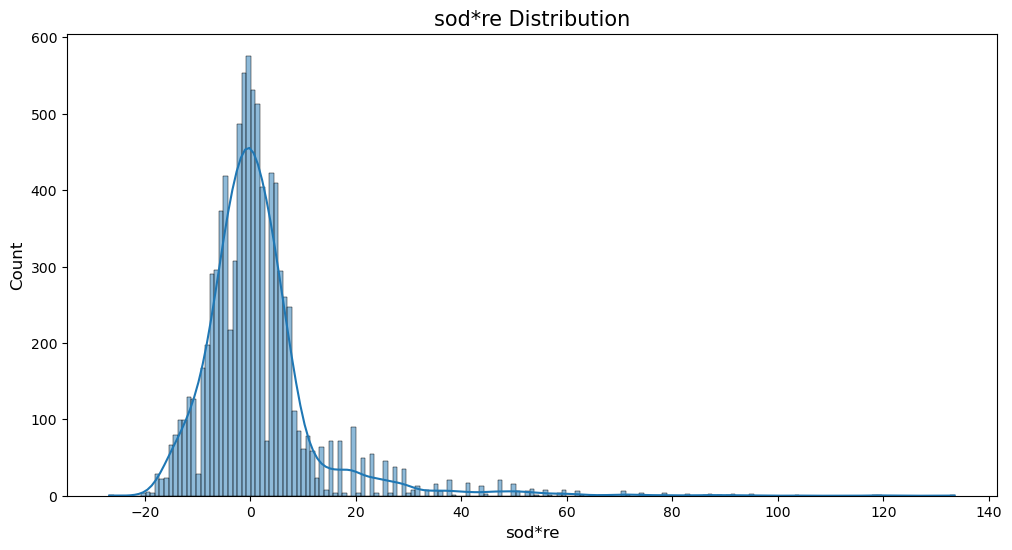

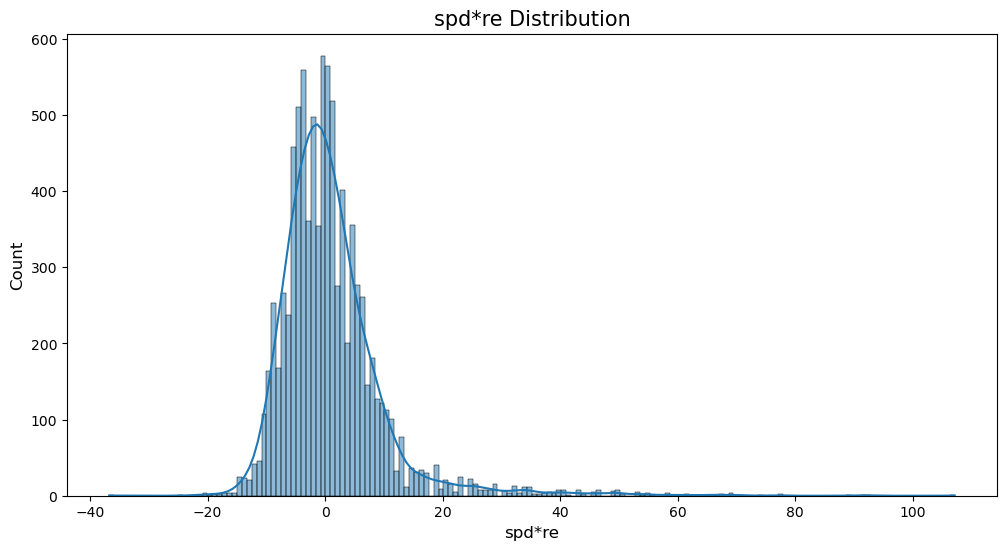

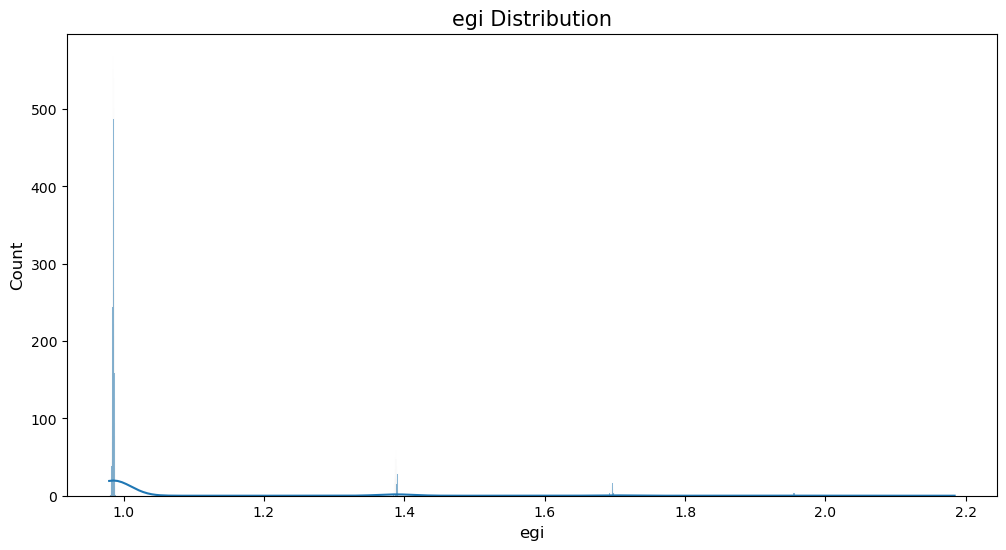

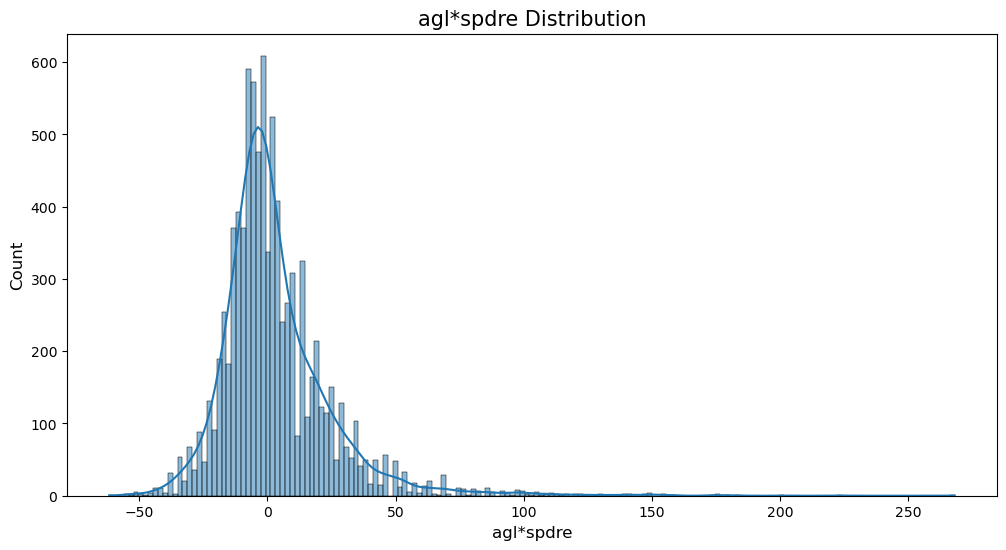

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# 카테고리컬 데이터 시각화
for col in categorical_cols:
    plt.figure(figsize=(12,6))
    sns.countplot(x=col, data=train)
    plt.title(col + ' Distribution', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()

# 넘버릭 데이터 시각화
for col in numerical_cols:
    plt.figure(figsize=(12,6))
    sns.histplot(train[col], kde=True)
    plt.title(col + ' Distribution', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()

In [12]:
y_pred

array([9.8335e+07, 6.7915e+07, 7.1200e+07, ..., 5.1100e+04, 4.9800e+04,
       5.6900e+04])

test data에 모델을 적용하기 위해서는 파생변수를 추가해줘야함.

In [13]:
test = pd.merge(test, create_new_variable(test), left_index=True, right_index=True)

In [14]:
test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,sod*re,spd*re,egi,age_group,age_group_level,agl*spdre
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0,131.945607,107.503487,2.184112,over 30,1.0,107.503487
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0,121.945607,102.503487,2.183289,26-30,2.0,205.006974
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0,93.369672,77.330538,1.957219,26-30,2.0,154.661076
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0,93.556485,74.002789,1.956989,26-30,2.0,148.005579
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0,93.369672,73.330538,1.956989,over 30,1.0,73.330538


In [15]:
# Predict on test data
y_test_pred = pipeline.predict(test)

In [16]:
y_test_pred

array([8.9260e+07, 8.3785e+07, 6.4435e+07, ..., 5.6400e+04, 4.1900e+04,
       4.3800e+04])